In [1]:
%pylab inline
import requests
import json

Populating the interactive namespace from numpy and matplotlib


# Get basic snapshot info

In [2]:
# This is our base url
base = "http://vm063.bridges.psc.edu:8001/"
response = requests.get(base)
print(response.url)
print(response.json())


http://vm063.bridges.psc.edu:8001/
{'msg': 'COSMO, a REST API for the BlueTides3 Cosmology Simulation Data'}


Now we want to look at the available snapshots and their basic information:

In [3]:
pig_url = base + "pig/"
response = requests.get(pig_url)
pig_list = json.loads(response.text)['LIST']
print('******************************PIG INFO*****************************')
for i in range(len(pig_list)):
    print('ID: ', pig_list[i]['id'],\
          ' FileName: ', pig_list[i]['name'], \
          ' Num halos: ', pig_list[i]['num_halos'], \
          ' Redshift: %.2f'%(pig_list[i]['time']))


******************************PIG INFO*****************************
ID:  208  FileName:  PIG_208  Num halos:  267649410  Redshift: 7.00
ID:  230  FileName:  PIG_230  Num halos:  276771522  Redshift: 6.85
ID:  237  FileName:  PIG_237  Num halos:  279858719  Redshift: 6.80
ID:  216  FileName:  PIG_216  Num halos:  271256543  Redshift: 6.94
ID:  265  FileName:  PIG_265  Num halos:  292040891  Redshift: 6.60
ID:  244  FileName:  PIG_244  Num halos:  282939566  Redshift: 6.75
ID:  271  FileName:  PIG_271  Num halos:  294288056  Redshift: 6.56
ID:  258  FileName:  PIG_258  Num halos:  289106271  Redshift: 6.65
ID:  222  FileName:  PIG_222  Num halos:  273696821  Redshift: 6.90
ID:  251  FileName:  PIG_251  Num halos:  286036300  Redshift: 6.70
ID:  184  FileName:  PIG_184  Num halos:  255434058  Redshift: 7.20
ID:  197  FileName:  PIG_197  Num halos:  261596356  Redshift: 7.10


## Read output from Snapshot/Single Halo

Before reading the data, let's first look at available particle types and fields within this snapshot

In [4]:
ptype_url = pig_url + '251'
requests.get(ptype_url).json()

{'id': 251,
 'subdirs': ['fofgroup', 'gas', 'dm', 'star', 'bh'],
 'num_gas': 19358022252,
 'num_dm': 21165203462,
 'num_star': 587619843,
 'num_bh': 235967}

We see that there are 4 types of particles(subdirectories) within snapshot 251, let's examine 'gas' first:

In [5]:
field_url = ptype_url + '/gas'
requests.get(field_url).json()

{'id': 251,
 'ptype': 'gas',
 'subdirs': ['JUV',
  'Mass',
  'Density',
  'Potential',
  'ElectronAbundance',
  'Pressure',
  'SmoothingLength',
  'H2Fraction',
  'Position',
  'GroupID',
  'InternalEnergy',
  'StarFormationRate',
  'EgyWtDensity',
  'Entropy',
  'ID',
  'Generation',
  'Metallicity',
  'NeutralHydrogenFraction',
  'Velocity']}

Now we get the available fields(subdirectories) of gas particles. Take a look at the position of the first halo:

In [6]:
# this is a function for getting requested field as a numpy array
import time

def get_group_data(group_url):
    t1 = time.time()
    response = requests.get(group_url)
    key = list(response.json().keys())[0]
    response_arr = json.loads(response.json()[key])
    response_arr = np.array(response_arr)
    t2 = time.time()
    print('Time to fetch from '+group_url+': %.2f s'%( t2-t1))
    return response_arr

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/gas/Position/1: 3.49 s


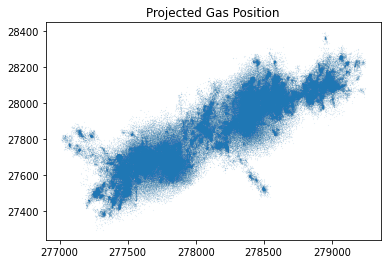

In [8]:
# url for positions of gas particles within Halo#1 in Snapshot#251
url =  field_url + "/Position/1"
gas_pos = get_group_data(url)
plt.scatter(gas_pos[:,0],gas_pos[:,1],s=0.001)
plt.title('Projected Gas Position')
plt.show()

Now let's add other particles to the plot:

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/dm/Position/1: 3.31 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/gas/Position/1: 2.65 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/star/Position/1: 3.69 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/Position/1: 0.22 s


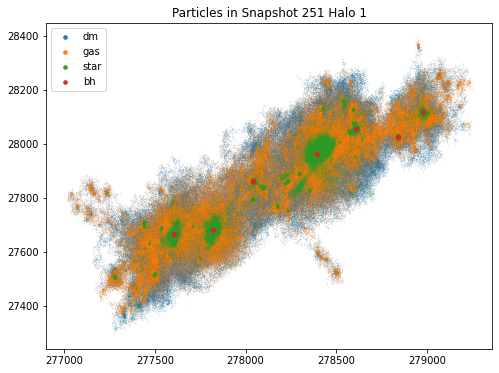

In [9]:
ptype = ['dm','gas','star','bh']
fig,ax = plt.subplots(figsize=(8,6))
for p in ptype:
    data_url = pig_url + '251/' + p + '/Position/1'
    pos = get_group_data(data_url)
    if p=='bh':
        ax.scatter(pos[:,0],pos[:,1],s=80,marker='.',label=p)
    else: 
        ax.scatter(pos[:,0],pos[:,1],s=0.01,marker='.',label=p)
plt.title('Particles in Snapshot 251 Halo 1')
leg = ax.legend()
for ll in leg.legendHandles:
    ll._sizes = [50]
plt.show()
    
    

### Mass functions

In [7]:
def mass_func(m,Lbox,lim_min,lim_max,nbin):
    mbin = np.logspace(lim_min,lim_max,nbin)
    binmid=np.log10(mbin)[:-1]+np.diff(np.log10(mbin))/2
    mhis = np.histogram(m,mbin)

    mask = mhis[0]>0
    Volumndlog = np.diff(np.log10(mbin))*(Lbox/hh)**3
    yy = mhis[0]/Volumndlog
    err = yy[mask]/np.sqrt(mhis[0][mask])
    y1 = np.log10(yy[mask]+err)
    y2 = yy[mask]-err
    y2[y2<=0] = 1e-50
    return (binmid[mask]),np.log10(yy[mask]), y1, np.log10(y2)

In [8]:
fof_url = pig_url + "251/fofgroup"

In [9]:
requests.get(fof_url).json()

{'id': 251,
 'fof_subdirs': ['Imom',
  'GroupID',
  'Mass',
  'Jmom',
  'OffsetByType',
  'BlackholeMass',
  'LengthByType',
  'FirstPos',
  'MassCenterPosition',
  'BlackholeAccretionRate',
  'MinID',
  'MassByType',
  'MassCenterVelocity',
  'StarFormationRate']}

In [10]:
gas_mass_url = fof_url + '/MassByType/all'
response = requests.get(gas_mass_url).json()

In [11]:
response

{'detail': [{'loc': ['path', 'group_id'],
   'msg': 'value is not a valid integer',
   'type': 'type_error.integer'}]}

### Advanced Queries

#### getting haloid and data by criterion

Now let's see how we can search for particular halos by their BH mass

This query returns the list of halo ids in which the total BH mass is between $10^8$ and $10^9$ $M_\odot$

In [20]:
t1 = time.time()
# this is the url to get haloid of halos whose total bhmass is between 1e8 and 1e9 Msun
response = requests.get(pig_url + "251/search_id/bh/MassByType",params={"min_range":1e-2,"max_range":1e-1})
t2 = time.time()
print('Time to fetch from '+response.url+': %.2f s'%( t2-t1))

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/search_id/bh/MassByType?min_range=0.01&max_range=0.1: 117.20 s


In [44]:
key = list(response.json().keys())[0]
haloid_list = json.loads(response.json()[key])[0]
print(haloid_list)

[0, 2, 3, 4, 5, 7, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 22, 24, 25, 26, 28, 32, 35, 36, 37, 39, 40, 44, 47, 49, 53, 56, 58, 59, 62, 63, 64, 72, 78, 80, 82, 83, 84, 86, 87, 88, 91, 93, 97, 98, 101, 109, 111, 112, 119, 127, 129, 135, 142, 143, 147, 155, 156, 168, 182, 184, 189, 197, 202, 203, 205, 216, 217, 220, 222, 226, 228, 231, 233, 239, 241, 247, 248, 255, 268, 276, 279, 294, 296, 299, 305, 308, 310, 322, 346, 351, 360, 367, 368, 377, 378, 395, 418, 425, 448, 461, 465, 468, 469, 475, 503, 522, 532, 538, 539, 556, 619, 624, 635, 641, 658, 660, 667, 670, 679, 739, 750, 773, 803, 811, 837, 917, 936, 950, 963, 975, 1007, 1016, 1060, 1086, 1087, 1101, 1159, 1165, 1253, 1338, 1340, 1365, 1395, 1483, 1485, 1497, 1660, 1681, 1698, 1798, 1837, 2034, 2235, 2340, 2360, 3290, 3733, 4435, 5346, 5477, 80663, 134265]


With the list above, we can then look at different kinds of data from those halos with BH mass between $10^8$ and $10^9$ $M_\odot$

For example, let's fetch the accretion rate of all BHs within those halos

In [41]:
# url for positions of gas particles within Halo#1 in Snapshot#251
url =  [pig_url + "251/bh/BlackholeAccretionRate/"+str(i+1) for i in haloid_list]
mdot = [get_group_data(u) for u in url]

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/1: 0.54 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/3: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/4: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/5: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/6: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/8: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/10: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/11: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/12: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/14: 0.01 s
Time to fetch from http://

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/369: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/378: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/379: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/396: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/419: 0.09 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/426: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/449: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/462: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/466: 0.01 s
Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/bh/BlackholeAccretionRate/469: 0.01 s
Time to fe

#### directly access data by criterion

or we can directly fetch data with a given criterion

In [55]:
t1 = time.time()
response = requests.get(pig_url + "251/search/bh/BlackholeMass/gas_mass",params={"min_range":1e-2,"max_range":2e-2})
t2 = time.time()
print('Time to fetch from '+response.url+': %.2f s'%( t2-t1))

Time to fetch from http://vm063.bridges.psc.edu:8001/pig/251/search/bh/BlackholeMass/gas_mass?min_range=0.01&max_range=0.02: 158.36 s


In [19]:
response

<Response [500]>